#**Sleep Health & Lifestyle Dataset**

**Imports & Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    average_precision_score
)

from statsmodels.stats.outliers_influence import variance_inflation_factor

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load and Pre-process Data**

In [ ]:
file_path = '/content/drive/MyDrive/Power BI Projects/Sleep_health_and_lifestyle_dataset.csv'
df = pd.read_csv(file_path)

**Feature Engineering**

In [ ]:
df['BMI Category'] = df['BMI Category'].replace('Normal Weight', 'Normal')
df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None').str.strip()
df['Has_Disorder'] = df['Sleep Disorder'].apply(lambda x: 0 if x == 'None' else 1)
df['BMI_Code'] = df['BMI Category'].map({'Normal': 0, 'Overweight': 1, 'Obese': 2})

**Drop unused columns**

In [ ]:
df = df.drop(columns=['Blood Pressure', 'Person ID'])

**Show class balance**

In [ ]:
print("Target class distribution (full dataset):")
print(df['Has_Disorder'].value_counts(normalize=True).round(3) * 100, "%\n")

Target class distribution (full dataset):
Has_Disorder
0    58.6
1    41.4
Name: proportion, dtype: float64 %



**VIF – Multicollinearity Check & Reduction**

In [ ]:
df_vif = df.copy()
df_vif['Gender']     = LabelEncoder().fit_transform(df_vif['Gender'])
df_vif['Occupation'] = LabelEncoder().fit_transform(df_vif['Occupation'])  # encoded but not used

**Features for initial VIF check (excluding target)**

In [ ]:
features_vif = [
    'Age', 'Gender', 'Sleep Duration', 'Quality of Sleep',
    'Physical Activity Level', 'Stress Level', 'BMI_Code',
    'Systolic', 'Diastolic', 'Heart Rate', 'Daily Steps'
]

X_vif_raw = df_vif[features_vif]
X_scaled_full = StandardScaler().fit_transform(X_vif_raw)
X_scaled_full = pd.DataFrame(X_scaled_full, columns=features_vif)

**Reduced feature set (after removing high-VIF pairs)**

In [ ]:
keep_features = ['Age', 'Gender', 'Sleep Duration', 'BMI_Code', 'Systolic', 'Heart Rate']

X_reduced_scaled = X_scaled_full[keep_features].copy()

**Final VIF on selected predictors**

In [ ]:
vif_final = pd.DataFrame({
    'Feature': X_reduced_scaled.columns,
    'VIF': [variance_inflation_factor(X_reduced_scaled.values, i) for i in range(X_reduced_scaled.shape[1])]
}).sort_values('VIF', ascending=False)

print("Final VIF values (predictors only):")
print(vif_final.round(2), "\n")

Final VIF values (predictors only):
          Feature   VIF
0             Age  4.38
4        Systolic  3.49
3        BMI_Code  3.06
2  Sleep Duration  1.95
5      Heart Rate  1.94
1          Gender  1.82 



**Final Modelling Data + Spearman Correlation**

Final modeling features: ['Age', 'Gender', 'Sleep Duration', 'BMI_Code', 'Systolic', 'Heart Rate']
X shape: (374, 6)  | y shape: (374,) 

Spearman Rank Correlation with Has_Disorder:
Has_Disorder      1.000
BMI_Code          0.806
Systolic          0.714
Age               0.451
Heart Rate        0.278
Gender           -0.286
Sleep Duration   -0.306
Name: Has_Disorder, dtype: float64 



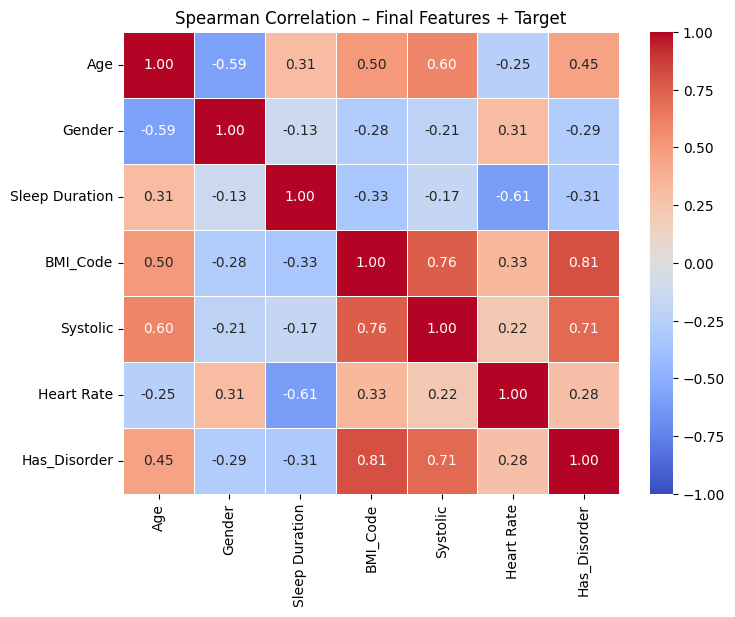

In [ ]:
X = X_reduced_scaled.copy()
y = df['Has_Disorder']

print("Final modeling features:", list(X.columns))
print("X shape:", X.shape, " | y shape:", y.shape, "\n")

df_for_corr = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)

spearman_corr = df_for_corr.corr(method='spearman')['Has_Disorder'].sort_values(ascending=False)

print("Spearman Rank Correlation with Has_Disorder:")
print(spearman_corr.round(3), "\n")

plt.figure(figsize=(8, 6))
sns.heatmap(
    df_for_corr.corr(method='spearman'),
    annot=True, cmap='coolwarm', fmt='.2f',
    vmin=-1, vmax=1, linewidths=0.4
)
plt.title("Spearman Correlation – Final Features + Target")
plt.show()

**Train / Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Train set class distribution:")
print(y_train.value_counts(normalize=True).round(3), "\n")

Train set class distribution:
Has_Disorder
0    0.585
1    0.415
Name: proportion, dtype: float64 



**Models**

In [ ]:
models = {}

# Logistic Regression
lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)
lr.fit(X_train, y_train)
models['Logistic Regression'] = lr

# Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
models['Random Forest'] = rf

**Single Hold-out Test Set Evaluation**


═══════════════════════════════════════════════════════════════════════════
Single Hold-out Test Set Performance (20% split)
═══════════════════════════════════════════════════════════════════════════

Logistic Regression:
              precision    recall  f1-score   support

           0      0.951     0.886     0.918        44
           1      0.853     0.935     0.892        31

    accuracy                          0.907        75
   macro avg      0.902     0.911     0.905        75
weighted avg      0.911     0.907     0.907        75

Accuracy      : 0.907
ROC AUC       : 0.938
PR AUC (AP)   : 0.909



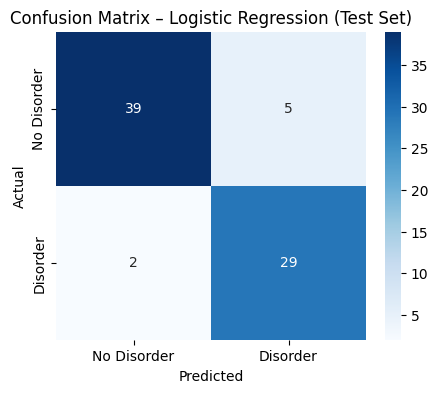

Random Forest:
              precision    recall  f1-score   support

           0      0.956     0.977     0.966        44
           1      0.967     0.935     0.951        31

    accuracy                          0.960        75
   macro avg      0.961     0.956     0.959        75
weighted avg      0.960     0.960     0.960        75

Accuracy      : 0.960
ROC AUC       : 0.950
PR AUC (AP)   : 0.945



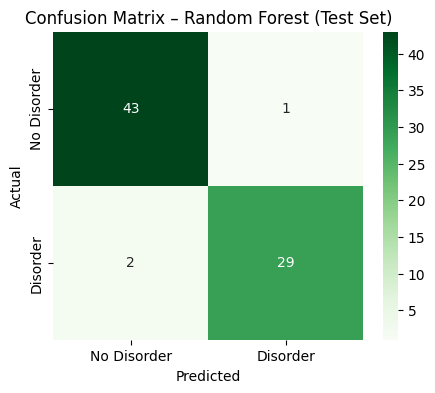

In [ ]:
print("\n" + "═"*75)
print("Single Hold-out Test Set Performance (20% split)")
print("═"*75 + "\n")

for name, model in models.items():
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"{name}:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"Accuracy      : {accuracy_score(y_test, y_pred):.3f}")
    print(f"ROC AUC       : {roc_auc_score(y_test, y_proba):.3f}")
    print(f"PR AUC (AP)   : {average_precision_score(y_test, y_proba):.3f}\n")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d',
                cmap='Blues' if 'Logistic' in name else 'Greens',
                xticklabels=['No Disorder', 'Disorder'],
                yticklabels=['No Disorder', 'Disorder'])
    plt.title(f'Confusion Matrix – {name} (Test Set)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


**5-Fold Stratified Cross-Validation**

In [ ]:
print("\n" + "═"*75)
print("5-Fold Stratified Cross-Validation Results")
print("═"*75 + "\n")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'roc_auc', 'average_precision']

for name, model in models.items():
    scores = cross_validate(
        model, X, y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )

    print(f"{name}:")
    for metric in scoring:
        mean_score = scores[f'test_{metric}'].mean()
        std_score  = scores[f'test_{metric}'].std()
        print(f"  {metric:14} : {mean_score:.3f} ± {std_score:.3f}")
    print()


═══════════════════════════════════════════════════════════════════════════
5-Fold Stratified Cross-Validation Results
═══════════════════════════════════════════════════════════════════════════

Logistic Regression:
  accuracy       : 0.917 ± 0.023
  roc_auc        : 0.942 ± 0.020
  average_precision : 0.922 ± 0.037

Random Forest:
  accuracy       : 0.944 ± 0.016
  roc_auc        : 0.937 ± 0.027
  average_precision : 0.899 ± 0.075



**Random Forest Feature Importance**


Random Forest Feature Importances:
BMI_Code          0.3525
Systolic          0.2748
Age               0.1516
Sleep Duration    0.1457
Heart Rate        0.0560
Gender            0.0194
dtype: float64 



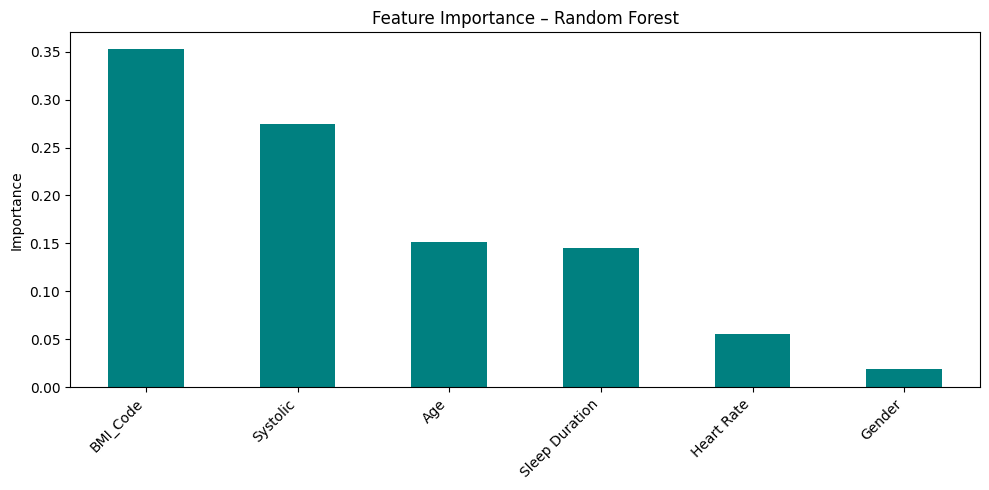

In [ ]:
importances = pd.Series(
    models['Random Forest'].feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print("\nRandom Forest Feature Importances:")
print(importances.round(4), "\n")

plt.figure(figsize=(10, 5))
importances.plot(kind='bar', color='teal')
plt.title('Feature Importance – Random Forest')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()